# Gridded Precipitation for Rain-on-Grid 2D Modeling

## Purpose

This notebook demonstrates **gridded precipitation (rain-on-grid)** workflows for 2D HEC-RAS models using HMS-validated precipitation methods. Unlike hydrograph boundary conditions, gridded precipitation applies directly to mesh cells.

**Scope**: Gridded precipitation for 2D rain-on-grid models

**For hydrograph boundary condition workflows**, see:
- `721_atlas14_comprehensive_workflow.ipynb` - Complete hydrograph BC workflow with bulk execution

## Workflow Overview

1. **Project Setup** - Extract BaldEagleCrkMulti2D project (configured for gridded precipitation)
2. **Mesh Analysis** - Extract and visualize 2D mesh cells that receive precipitation
3. **Storm Generation** - Generate uniform storms using all HMS-validated methods
4. **Spatial Variance Assessment** - Assess whether uniform rainfall is appropriate
5. **Gridded Precipitation Concept** - Future conversion workflow (placeholder)
6. **Execution** - Optional plan execution with results extraction

## Key Difference: Gridded vs Hydrograph Precipitation

| Aspect | Hydrograph BC (Notebook 721) | Gridded Precipitation (This Notebook) |
|--------|------------------------------|---------------------------------------|
| **Input Type** | Time series at boundary | Spatially distributed over mesh |
| **Application** | Upstream/downstream BCs | Rain-on-grid 2D modeling |
| **Project** | Davis (1D inflows) | BaldEagleCrkMulti2D (2D mesh) |
| **Spatial Variance** | Not applicable | Critical consideration |

## Prerequisites

- **HEC-RAS 6.5+** installed (for plan execution)
- **hms-commander** package (for HMS-equivalent methods)
- **BaldEagleCrkMulti2D** example project (included with ras-commander)

## Related Notebooks

- `720_precipitation_methods_comprehensive.ipynb` - Method comparison (no execution)
- `721_atlas14_comprehensive_workflow.ipynb` - Hydrograph BC workflow
- `725_atlas14_spatial_variance.ipynb` - Spatial variance analysis (detailed)

---

## Part 1: Setup and Imports

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = True  # Set to True for local development, False for pip package

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander core
from ras_commander import (
    RasExamples, 
    init_ras_project, 
    ras,
    RasCmdr, 
    RasPlan,
    RasPrj
)
from ras_commander.hdf import HdfResultsPlan, HdfMesh

# Import precipitation modules
from ras_commander.precip import (
    StormGenerator,                # Alternating Block Method (NOT HMS-equivalent)
    Atlas14Storm,                  # HMS-equivalent Atlas 14 temporal distributions
    FrequencyStorm,                # HMS-equivalent TP-40 temporal pattern
    ScsTypeStorm,                  # HMS-equivalent SCS Type I/IA/II/III
    Atlas14Grid,                   # Gridded PFE access
    Atlas14Variance,               # Spatial variance analysis
    ATLAS14_AVAILABLE,             # Availability flag for Atlas14Storm
    FREQUENCY_STORM_AVAILABLE,     # Availability flag for FrequencyStorm
    SCS_TYPE_AVAILABLE             # Availability flag for ScsTypeStorm
)

import ras_commander
print(f"Loaded ras_commander: {ras_commander.__file__}")

# Check HMS-equivalent method availability
print(f"\nHMS-Equivalent Methods Availability:")
print(f"  Atlas14Storm:   {'[OK]' if ATLAS14_AVAILABLE else '[--]'}")
print(f"  FrequencyStorm: {'[OK]' if FREQUENCY_STORM_AVAILABLE else '[--]'}")
print(f"  ScsTypeStorm:   {'[OK]' if SCS_TYPE_AVAILABLE else '[--]'}")

if not (ATLAS14_AVAILABLE and FREQUENCY_STORM_AVAILABLE and SCS_TYPE_AVAILABLE):
    print("\n  Install hms-commander for all HMS-equivalent methods:")
    print("  pip install hms-commander")

LOCAL SOURCE MODE: Loading from c:\GH\ras-commander/ras_commander
Loaded ras_commander: c:\GH\ras-commander\ras_commander\__init__.py

HMS-Equivalent Methods Availability:
  Atlas14Storm:   [OK]
  FrequencyStorm: [OK]
  ScsTypeStorm:   [OK]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Configure output
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Standard libraries imported successfully")

Standard libraries imported successfully


In [3]:
# =============================================================================
# CONFIGURATION - Edit these for your project
# =============================================================================

# Project Configuration
PROJECT_NAME = "BaldEagleCrkMulti2D"  # Example project with 2D mesh
RAS_VERSION = "6.6"                    # HEC-RAS version
TEMPLATE_PLAN = "06"                   # Plan 06 is configured for gridded precipitation

# Storm Parameters
STORM_DURATION_HOURS = 24         # 24-hour storm
TIME_INTERVAL_MIN = 60            # 1-hour intervals for output

# Demonstration AEP (single event for this notebook)
# Using 100-year event as representative design storm
DEMO_AEP_PERCENT = 1.0            # 1% AEP = 100-year event
DEMO_AEP_NAME = "100yr"

# Execution Control
# WARNING: Set to True to execute HEC-RAS Plan 06
EXECUTE_PLAN = True              # Set to True to run HEC-RAS
NUM_CORES = 2                     # CPU cores for execution

# Spatial Variance Threshold
# If variance exceeds this threshold, spatially variable rainfall should be considered
VARIANCE_THRESHOLD_PCT = 10.0     # Percent range threshold

print("Configuration Summary:")
print(f"  Project: {PROJECT_NAME}")
print(f"  Plan: {TEMPLATE_PLAN} (configured for gridded precipitation)")
print(f"  Storm Duration: {STORM_DURATION_HOURS} hours")
print(f"  Demo AEP: {DEMO_AEP_NAME} ({DEMO_AEP_PERCENT}% AEP)")
print(f"  Execute Plan: {EXECUTE_PLAN}")
print(f"  Variance Threshold: {VARIANCE_THRESHOLD_PCT}%")

Configuration Summary:
  Project: BaldEagleCrkMulti2D
  Plan: 06 (configured for gridded precipitation)
  Storm Duration: 24 hours
  Demo AEP: 100yr (1.0% AEP)
  Execute Plan: True
  Variance Threshold: 10.0%


In [4]:
# =============================================================================
# 1.1 Extract Example Project
# =============================================================================
print("Extracting BaldEagleCrkMulti2D example project...")

try:
    # Extract with suffix to avoid conflicts
    project_path = RasExamples.extract_project(PROJECT_NAME, suffix="722_gridded")
    print(f"[OK] Extracted to: {project_path}")
    
    # Verify path exists
    if not project_path.exists():
        raise FileNotFoundError(f"Project not found at {project_path}")
        
    PROJECT_AVAILABLE = True
    
except Exception as e:
    print(f"[!!] Error extracting project: {e}")
    PROJECT_AVAILABLE = False
    project_path = None

2026-01-06 21:10:26 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip
2026-01-06 21:10:26 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip
2026-01-06 21:10:26 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2026-01-06 21:10:26 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2026-01-06 21:10:26 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2026-01-06 21:10:26 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2026-01-06 21:10:26 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-06 21:10:26 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-06 21:10:26 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D' as 'BaldEagleCrkMulti2D_722_gridded'
2026-01-06 21:10:26 - ras_commander.RasExamples - INFO - Ex

Extracting BaldEagleCrkMulti2D example project...


2026-01-06 21:10:28 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded
2026-01-06 21:10:28 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded


[OK] Extracted to: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded


In [5]:
# =============================================================================
# 1.2 Initialize Project
# =============================================================================
if PROJECT_AVAILABLE:
    print("Initializing HEC-RAS project...")
    
    init_ras_project(project_path, RAS_VERSION)
    
    print(f"\n[OK] Project initialized: {ras.project_name}")
    print(f"  Project folder: {ras.project_folder}")
    print(f"  Plans available: {len(ras.plan_df)}")
    print(f"  Geometries available: {len(ras.geom_df)}")
    
    # Display available plans
    print("\nAvailable Plans:")
    display(ras.plan_df[['plan_number', 'Plan Title', 'Geom File', 'Flow File']])
else:
    print("[!!] Project not available - cannot continue")

2026-01-06 21:10:28 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.rasmap
2026-01-06 21:10:28 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.rasmap


Initializing HEC-RAS project...

[OK] Project initialized: BaldEagleDamBrk
  Project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded
  Plans available: 11
  Geometries available: 10

Available Plans:


,plan_number,Plan Title,Geom File,Flow File
0,13,PMF with Multi 2D Areas,06,07
1,15,1d-2D Dambreak Refined Grid,08,12
2,17,2D to 1D No Dam,10,09
3,18,2D to 2D Run,11,10
4,19,SA to 2D Dam Break Run,12,11
5,03,Single 2D Area - Internal Dam Structure,09,13
6,04,SA to 2D Area Conn - 2D Levee Structure,13,01
7,02,SA to Detailed 2D Breach,01,01
8,01,SA to Detailed 2D Breach FEQ,01,01
9,05,Single 2D area with Bridges FEQ,03,02


In [6]:
# =============================================================================
# 1.3 Verify Gridded Precipitation Configuration
# =============================================================================
if PROJECT_AVAILABLE:
    print(f"Verifying Plan {TEMPLATE_PLAN} for gridded precipitation...")
    
    # Check if plan exists
    plan_row = ras.plan_df[ras.plan_df['plan_number'] == TEMPLATE_PLAN]
    
    if len(plan_row) > 0:
        print(f"\n[OK] Plan {TEMPLATE_PLAN} found:")
        print(f"  Title: {plan_row['Plan Title'].values[0]}")
        print(f"  Geometry: {plan_row['Geom File'].values[0]}")
        print(f"  Flow: {plan_row['Flow File'].values[0]}")
        PLAN_AVAILABLE = True
    else:
        print(f"\n[!!] Plan {TEMPLATE_PLAN} not found!")
        print(f"  Available plans: {ras.plan_df['plan_number'].tolist()}")
        PLAN_AVAILABLE = False
        
    # Find geometry HDF
    geom_hdfs = list(project_path.glob("*.g*.hdf"))
    if geom_hdfs:
        geom_hdf = geom_hdfs[0]
        print(f"\n[OK] Geometry HDF: {geom_hdf.name}")
    else:
        print("\n[!!] No geometry HDF found")
        geom_hdf = None
else:
    PLAN_AVAILABLE = False
    geom_hdf = None

Verifying Plan 06 for gridded precipitation...

[OK] Plan 06 found:
  Title: Gridded Precip - Infiltration
  Geometry: 09
  Flow: 03

[OK] Geometry HDF: BaldEagleDamBrk.g01.hdf


---

## Part 2: Mesh Analysis

Extract and visualize the 2D mesh cells that will receive precipitation. Each mesh cell in a rain-on-grid model receives precipitation input independently.

In [7]:
# =============================================================================
# 2.1 Get 2D Mesh Area Names
# =============================================================================
if PROJECT_AVAILABLE and geom_hdf:
    print("Extracting 2D mesh area names...")
    
    mesh_area_names = HdfMesh.get_mesh_area_names(geom_hdf)
    
    if mesh_area_names:
        print(f"\n[OK] Found {len(mesh_area_names)} 2D flow area(s):")
        for name in mesh_area_names:
            print(f"  - {name}")
    else:
        print("\n[!!] No 2D flow areas found in geometry")
else:
    print("[!!] Project or geometry HDF not available")
    mesh_area_names = []

2026-01-06 21:10:28 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:28 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:28 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:28 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf


Extracting 2D mesh area names...

[OK] Found 1 2D flow area(s):
  - BaldEagleCr


In [8]:
# =============================================================================
# 2.2 Extract Mesh Cell Points
# =============================================================================
if PROJECT_AVAILABLE and geom_hdf and mesh_area_names:
    print("Extracting mesh cell center points...")
    
    try:
        mesh_cells_gdf = HdfMesh.get_mesh_cell_points(geom_hdf)
        
        print(f"\n[OK] Extracted {len(mesh_cells_gdf)} mesh cell center points")
        print(f"\nMesh cell statistics:")
        print(f"  Total cells: {len(mesh_cells_gdf)}")
        
        # Show by mesh area
        if 'mesh_name' in mesh_cells_gdf.columns:
            print(f"\nCells by 2D flow area:")
            cell_counts = mesh_cells_gdf.groupby('mesh_name').size()
            for name, count in cell_counts.items():
                print(f"  {name}: {count:,} cells")
        
        # Show sample
        print(f"\nSample cells:")
        display(mesh_cells_gdf.head())
        
    except Exception as e:
        print(f"[!!] Error extracting mesh cells: {e}")
        mesh_cells_gdf = None
else:
    print("[!!] Cannot extract mesh cells - prerequisites not available")
    mesh_cells_gdf = None

2026-01-06 21:10:28 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:28 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:28 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:28 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:28 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:28 - ras_commander.hdf.

Extracting mesh cell center points...


2026-01-06 21:10:29 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:29 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:29 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:29 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:29 - ras_commander.hdf.HdfBase - INFO - Found projection in RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\Terrain\Projection.prj
2026-01-06 21:10:29 - ras_commander.hdf.


[OK] Extracted 89879 mesh cell center points

Mesh cell statistics:
  Total cells: 89879

Cells by 2D flow area:
  BaldEagleCr: 89,879 cells

Sample cells:


,mesh_name,cell_id,geometry
0,BaldEagleCr,0,POINT (2083700 370900)
1,BaldEagleCr,1,POINT (2083800 370900)
2,BaldEagleCr,2,POINT (2083900 370900)
3,BaldEagleCr,3,POINT (2084000 370900)
4,BaldEagleCr,4,POINT (2084100 370900)


In [9]:
# =============================================================================
# 2.3 Extract Mesh Area Perimeters
# =============================================================================
if PROJECT_AVAILABLE and geom_hdf:
    print("Extracting 2D flow area perimeters...")
    
    try:
        mesh_areas_gdf = HdfMesh.get_mesh_areas(geom_hdf)
        
        if len(mesh_areas_gdf) > 0:
            print(f"\n[OK] Extracted {len(mesh_areas_gdf)} 2D flow area perimeter(s)")
            
            # Calculate area in square miles (approximate)
            # Note: This assumes projected CRS - actual calculation depends on projection
            print(f"\nFlow area bounds:")
            bounds = mesh_areas_gdf.total_bounds
            print(f"  Min X: {bounds[0]:.2f}")
            print(f"  Min Y: {bounds[1]:.2f}")
            print(f"  Max X: {bounds[2]:.2f}")
            print(f"  Max Y: {bounds[3]:.2f}")
        else:
            print("\n[!!] No mesh area perimeters found")
            
    except Exception as e:
        print(f"[!!] Error extracting mesh areas: {e}")
        mesh_areas_gdf = None
else:
    mesh_areas_gdf = None

2026-01-06 21:10:29 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:29 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:29 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:29 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:29 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:29 - ras_commander.hdf.

Extracting 2D flow area perimeters...

[OK] Extracted 1 2D flow area perimeter(s)

Flow area bounds:
  Min X: 2000930.70
  Min Y: 320392.94
  Max X: 2084790.14
  Max Y: 371007.58


Visualizing mesh domain...


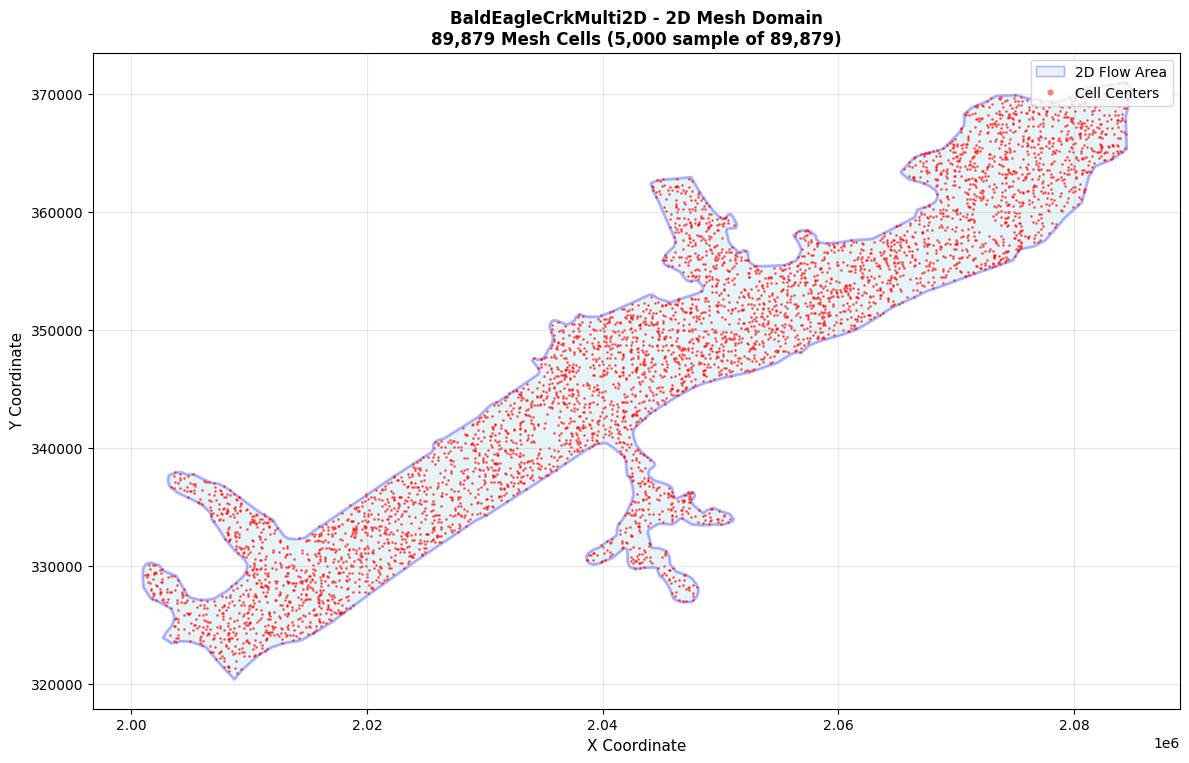

[OK] Mesh domain visualized
Note: In rain-on-grid modeling, each of these 89,879 cells
      receives precipitation input independently.


In [10]:
# =============================================================================
# 2.4 Visualize Mesh Domain
# =============================================================================
if mesh_cells_gdf is not None and mesh_areas_gdf is not None:
    print("Visualizing mesh domain...")

    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot mesh area perimeters
    mesh_areas_gdf.plot(ax=ax, facecolor='lightblue', edgecolor='blue',
                        linewidth=2, alpha=0.3)

    # Plot mesh cell points (sample if too many)
    n_cells = len(mesh_cells_gdf)
    if n_cells > 5000:
        # Sample for visualization
        sample_gdf = mesh_cells_gdf.sample(n=5000, random_state=42)
        sample_note = f" (5,000 sample of {n_cells:,})"
    else:
        sample_gdf = mesh_cells_gdf
        sample_note = ""

    sample_gdf.plot(ax=ax, markersize=1, color='red', alpha=0.5)

    # Create custom legend handles (geopandas plot doesn't support 'label' well)
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [
        Patch(facecolor='lightblue', edgecolor='blue', alpha=0.3, label='2D Flow Area'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
               markersize=5, alpha=0.5, label='Cell Centers')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    ax.set_xlabel('X Coordinate', fontsize=11)
    ax.set_ylabel('Y Coordinate', fontsize=11)
    title_str = (f'BaldEagleCrkMulti2D - 2D Mesh Domain\n'
                 f'{n_cells:,} Mesh Cells{sample_note}')
    ax.set_title(title_str,
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("[OK] Mesh domain visualized")
    print(f"Note: In rain-on-grid modeling, each of these {n_cells:,} cells")
    print("      receives precipitation input independently.")
else:
    print("[--] Cannot visualize - mesh data not available")


---

## Part 3: Generate Uniform Storms (All HMS Methods)

For **demonstration purposes**, we generate **uniform (spatially invariant)** storms. In uniform rainfall, every mesh cell receives the same precipitation depth over time.

This notebook generates representative storms using all 4 available HMS methods:
1. **Atlas14Storm** - 2 quartiles (All Cases, Fourth Quartile)
2. **FrequencyStorm** - TP-40 pattern
3. **ScsTypeStorm** - Type II (standard for most of US)

**Note**: These are uniform storms - the depth is the same everywhere. Part 4 assesses whether spatial variation is needed.

In [11]:
# =============================================================================
# 3.1 Get Representative Precipitation Depth
# =============================================================================
if PROJECT_AVAILABLE and geom_hdf:
    print("Getting representative precipitation depth for model domain...")
    
    try:
        # Use Atlas14Variance to get representative depth
        quick_stats = Atlas14Variance.analyze_quick(
            geom_hdf=geom_hdf,
            duration=STORM_DURATION_HOURS,
            return_period=int(100 / DEMO_AEP_PERCENT)  # Convert AEP to return period
        )
        
        # Use mean depth for uniform rainfall
        TOTAL_DEPTH_INCHES = quick_stats['mean']
        
        print(f"\n[OK] Atlas 14 PFE for project domain ({DEMO_AEP_NAME}, {STORM_DURATION_HOURS}-hr):")
        print(f"  Min: {quick_stats['min']:.2f} inches")
        print(f"  Max: {quick_stats['max']:.2f} inches")
        print(f"  Mean: {quick_stats['mean']:.2f} inches (using for uniform rainfall)")
        print(f"  Range: {quick_stats['range']:.2f} inches ({quick_stats['range_pct']:.1f}%)")
        
        DEPTH_AVAILABLE = True
        
    except Exception as e:
        print(f"[!!] Error getting precipitation depth: {e}")
        print("\nUsing default depth for demonstration...")
        TOTAL_DEPTH_INCHES = 5.75  # Approximate for Pennsylvania 100-yr 24-hr
        DEPTH_AVAILABLE = False
        
    print(f"\nUsing total depth: {TOTAL_DEPTH_INCHES:.2f} inches")
else:
    print("[!!] Project not available")
    TOTAL_DEPTH_INCHES = 5.75
    DEPTH_AVAILABLE = False

2026-01-06 21:10:29 - ras_commander.precip.Atlas14Variance - INFO - Starting Atlas 14 variance analysis for BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:29 - ras_commander.precip.Atlas14Variance - INFO - Starting Atlas 14 variance analysis for BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:29 - ras_commander.precip.Atlas14Variance - INFO - Durations: [24] hours, Return periods: [100] years
2026-01-06 21:10:29 - ras_commander.precip.Atlas14Variance - INFO - Durations: [24] hours, Return periods: [100] years
2026-01-06 21:10:29 - ras_commander.precip.Atlas14Grid - INFO - Extracting extent from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf using 2d_flow_area
2026-01-06 21:10:29 - ras_commander.precip.Atlas14Grid - INFO - Extracting extent from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf using 2d_flow_area
2026-01-06 21:10:29 - ras_commander.hdf.HdfMesh - INFO - Using existing Path objec

Getting representative precipitation depth for model domain...


2026-01-06 21:10:40 - ras_commander.precip.Atlas14Grid - INFO - Loaded coordinates: lat=3121, lon=7081, ari=9
2026-01-06 21:10:40 - ras_commander.precip.Atlas14Grid - INFO - Loaded coordinates: lat=3121, lon=7081, ari=9
2026-01-06 21:10:40 - ras_commander.precip.Atlas14Grid - INFO - Extracting Atlas 14 data for bounds (-77.6629, 41.0321, -77.2970, 41.1980): lat[2044:2064], lon[5681:5725]
2026-01-06 21:10:40 - ras_commander.precip.Atlas14Grid - INFO - Extracting Atlas 14 data for bounds (-77.6629, 41.0321, -77.2970, 41.1980): lat[2044:2064], lon[5681:5725]
2026-01-06 21:10:45 - ras_commander.precip.Atlas14Grid - INFO - Data transfer: 15.5 KB (vs 379.4 MB full grid, 100.0% reduction)
2026-01-06 21:10:45 - ras_commander.precip.Atlas14Grid - INFO - Data transfer: 15.5 KB (vs 379.4 MB full grid, 100.0% reduction)
2026-01-06 21:10:45 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagl


[OK] Atlas 14 PFE for project domain (100yr, 24-hr):
  Min: 5.61 inches
  Max: 5.94 inches
  Mean: 5.75 inches (using for uniform rainfall)
  Range: 0.33 inches (5.9%)

Using total depth: 5.75 inches


In [12]:
# =============================================================================
# 3.2 Generate Storms Using All Available Storm Methods
# =============================================================================
print("="*80)
print(f"GENERATING UNIFORM STORM SUITE ({DEMO_AEP_NAME}, {STORM_DURATION_HOURS}-hr)")
print("="*80)
print(f"\nTotal Depth: {TOTAL_DEPTH_INCHES:.2f} inches")

storms_suite = {}

# ----- Atlas14Storm: 2 Quartiles -----
if ATLAS14_AVAILABLE:
    print("\n  Atlas14Storm (HMS-equivalent, NOAA patterns):")
    
    # Determine state and region from project location
    # BaldEagleCrkMulti2D is in Pennsylvania (PA), Region 1
    STATE = "pa"   # Pennsylvania
    REGION = 1     # Atlas 14 Region 1
    
    quartiles = ["All Cases", "Fourth Quartile"]
    
    for quartile in quartiles:
        short_name = quartile.replace(" ", "").replace("Quartile", "Q")
        key = f"Atlas14_{short_name}"
        
        try:
            hyeto = Atlas14Storm.generate_hyetograph(
                total_depth_inches=TOTAL_DEPTH_INCHES,
                state=STATE,
                region=REGION,
                duration_hours=STORM_DURATION_HOURS,
                aep_percent=DEMO_AEP_PERCENT,
                quartile=quartile
            )
            storms_suite[key] = hyeto
            print(f"    [OK] {key}: {len(hyeto)} steps, {hyeto['incremental_depth'].sum():.6f} in")
        except Exception as e:
            print(f"    [!!] {key}: Error - {e}")
else:
    print("\n  [--] Atlas14Storm not available")

# ----- FrequencyStorm: TP-40 -----
if FREQUENCY_STORM_AVAILABLE:
    print("\n  FrequencyStorm (HMS-equivalent, TP-40):")
    key = "FrequencyStorm_TP40"
    
    try:
        hyeto = FrequencyStorm.generate_hyetograph(
            total_depth_inches=TOTAL_DEPTH_INCHES,
            total_duration_min=STORM_DURATION_HOURS * 60,
            time_interval_min=TIME_INTERVAL_MIN,
            peak_position_pct=67.0  # TP-40 standard
        )
        storms_suite[key] = hyeto
        print(f"    [OK] {key}: {len(hyeto)} steps, {hyeto['incremental_depth'].sum():.6f} in")
    except Exception as e:
        print(f"    [!!] {key}: Error - {e}")
else:
    print("\n  [--] FrequencyStorm not available")

# ----- ScsTypeStorm: Type II -----
if SCS_TYPE_AVAILABLE:
    print("\n  ScsTypeStorm (HMS-equivalent, TR-55):")
    key = "ScsType_II"
    
    try:
        hyeto = ScsTypeStorm.generate_hyetograph(
            total_depth_inches=TOTAL_DEPTH_INCHES,
            scs_type='II',
            time_interval_min=TIME_INTERVAL_MIN
        )
        storms_suite[key] = hyeto
        print(f"    [OK] {key}: {len(hyeto)} steps, {hyeto['incremental_depth'].sum():.6f} in")
    except Exception as e:
        print(f"    [!!] {key}: Error - {e}")
else:
    print("\n  [--] ScsTypeStorm not available")

# Summary
print("\n" + "="*80)
print(f"STORM GENERATION COMPLETE: {len(storms_suite)} storms generated")
print("="*80)

2026-01-06 21:10:45 - hms_commander.Atlas14Storm - INFO - Downloading temporal distribution from: https://hdsc.nws.noaa.gov/pub/hdsc/data/pa/pa_1_24h_temporal.csv
2026-01-06 21:10:45 - hms_commander.Atlas14Storm - INFO - Downloading temporal distribution from: https://hdsc.nws.noaa.gov/pub/hdsc/data/pa/pa_1_24h_temporal.csv


GENERATING UNIFORM STORM SUITE (100yr, 24-hr)

Total Depth: 5.75 inches

  Atlas14Storm (HMS-equivalent, NOAA patterns):


2026-01-06 21:10:45 - hms_commander.Atlas14Storm - INFO - Downloading temporal distribution from: https://hdsc.nws.noaa.gov/pub/hdsc/data/pa/pa_1_24h_temporal.csv
2026-01-06 21:10:45 - hms_commander.Atlas14Storm - INFO - Downloading temporal distribution from: https://hdsc.nws.noaa.gov/pub/hdsc/data/pa/pa_1_24h_temporal.csv


    [!!] Atlas14_AllCases: Error - Duration 24h is not available for PA region 1.
This region may only have 24-hour temporal distributions.
Try duration_hours=24 or use StormGenerator for other durations.


2026-01-06 21:10:46 - hms_commander.ScsTypeStorm - INFO - Generated SCS Type II hyetograph: 25 intervals, 5.753951 inches total, peak 2.463 inches
2026-01-06 21:10:46 - hms_commander.ScsTypeStorm - INFO - Generated SCS Type II hyetograph: 25 intervals, 5.753951 inches total, peak 2.463 inches


    [!!] Atlas14_FourthQ: Error - Duration 24h is not available for PA region 1.
This region may only have 24-hour temporal distributions.
Try duration_hours=24 or use StormGenerator for other durations.

  FrequencyStorm (HMS-equivalent, TP-40):
    [OK] FrequencyStorm_TP40: 25 steps, 5.753951 in

  ScsTypeStorm (HMS-equivalent, TR-55):
    [OK] ScsType_II: 25 steps, 5.753951 in

STORM GENERATION COMPLETE: 2 storms generated


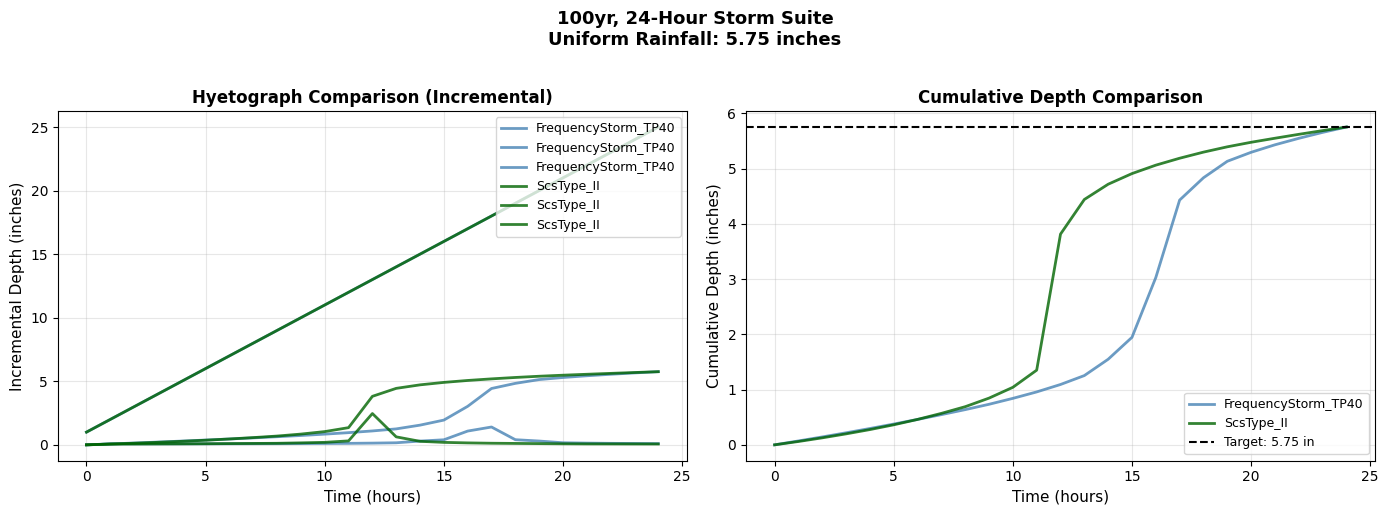


Depth Conservation Summary:
------------------------------------------------------------
Storm Type                    Total Depth           Error
------------------------------------------------------------
FrequencyStorm_TP40              5.753951     0.000000000
ScsType_II                       5.753951     0.000000000
------------------------------------------------------------

Note: HMS-equivalent methods conserve depth at 10^-6 precision.


In [13]:
# =============================================================================
# 3.3 Visualize Generated Storms
# =============================================================================
if storms_suite:
    n_storms = len(storms_suite)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Incremental Depth (Hyetographs)
    ax1 = axes[0]
    colors = ['steelblue', 'darkgreen', 'darkorange', 'darkred']
    
    for idx, (name, hyeto) in enumerate(storms_suite.items()):
        color = colors[idx % len(colors)]
        
        # Determine time axis based on hyetograph length
        if 'Atlas14' in name:
            # Atlas14 uses 30-min intervals
            time_hours = np.arange(len(hyeto)) * 0.5
        else:
            # FrequencyStorm and ScsType use TIME_INTERVAL_MIN
            time_hours = np.arange(len(hyeto)) * TIME_INTERVAL_MIN / 60
        
        ax1.plot(time_hours, hyeto, linewidth=2, label=name, color=color, alpha=0.8)
    
    ax1.set_xlabel('Time (hours)', fontsize=11)
    ax1.set_ylabel('Incremental Depth (inches)', fontsize=11)
    ax1.set_title('Hyetograph Comparison (Incremental)', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Cumulative Depth
    ax2 = axes[1]
    
    for idx, (name, hyeto) in enumerate(storms_suite.items()):
        color = colors[idx % len(colors)]
        
        if 'Atlas14' in name:
            time_hours = np.arange(len(hyeto)) * 0.5
        else:
            time_hours = np.arange(len(hyeto)) * TIME_INTERVAL_MIN / 60
        
        ax2.plot(time_hours, hyeto['cumulative_depth'], linewidth=2, label=name, color=color, alpha=0.8)
    
    ax2.axhline(TOTAL_DEPTH_INCHES, color='black', linestyle='--', linewidth=1.5, 
               label=f'Target: {TOTAL_DEPTH_INCHES:.2f} in')
    
    ax2.set_xlabel('Time (hours)', fontsize=11)
    ax2.set_ylabel('Cumulative Depth (inches)', fontsize=11)
    ax2.set_title('Cumulative Depth Comparison', fontsize=12, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'{DEMO_AEP_NAME}, {STORM_DURATION_HOURS}-Hour Storm Suite\nUniform Rainfall: {TOTAL_DEPTH_INCHES:.2f} inches', 
                 fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print depth conservation summary
    print("\nDepth Conservation Summary:")
    print("-" * 60)
    print(f"{'Storm Type':<25s} {'Total Depth':>15s} {'Error':>15s}")
    print("-" * 60)
    for name, hyeto in storms_suite.items():
        total = hyeto['incremental_depth'].sum()
        error = abs(total - TOTAL_DEPTH_INCHES)
        print(f"{name:<25s} {total:>15.6f} {error:>15.9f}")
    print("-" * 60)
    print("\nNote: HMS-equivalent methods conserve depth at 10^-6 precision.")
else:
    print("[--] No storms generated")

---

## Part 4: Spatial Variance Assessment

Before applying uniform rainfall to all mesh cells, we should assess whether spatial variation exists in the Atlas 14 precipitation data across the model domain.

**Decision Criterion**:
- If range percentage **< 10%**: Uniform rainfall is appropriate
- If range percentage **>= 10%**: Consider spatially variable rainfall

In [14]:
# =============================================================================
# 4.1 Full Variance Analysis
# =============================================================================
if PROJECT_AVAILABLE and geom_hdf:
    print("Running spatial variance analysis...")
    
    try:
        # Analyze across multiple durations and return periods
        variance_results = Atlas14Variance.analyze(
            geom_hdf=geom_hdf,
            durations=[6, 12, 24],
            return_periods=[10, 50, 100],
            extent_source="2d_flow_area",
            variance_denominator='min'
        )
        
        print("\n[OK] Variance analysis complete")
        print("\nVariance Statistics:")
        display(variance_results[['mesh_area', 'duration_hr', 'return_period_yr', 
                                  'min_inches', 'max_inches', 'mean_inches', 'range_pct']])
        
        VARIANCE_AVAILABLE = True
        
    except Exception as e:
        print(f"[!!] Error in variance analysis: {e}")
        variance_results = None
        VARIANCE_AVAILABLE = False
else:
    print("[!!] Cannot run variance analysis - project not available")
    variance_results = None
    VARIANCE_AVAILABLE = False

2026-01-06 21:10:46 - ras_commander.precip.Atlas14Variance - INFO - Starting Atlas 14 variance analysis for BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:46 - ras_commander.precip.Atlas14Variance - INFO - Starting Atlas 14 variance analysis for BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:46 - ras_commander.precip.Atlas14Variance - INFO - Durations: [6, 12, 24] hours, Return periods: [10, 50, 100] years
2026-01-06 21:10:46 - ras_commander.precip.Atlas14Variance - INFO - Durations: [6, 12, 24] hours, Return periods: [10, 50, 100] years
2026-01-06 21:10:46 - ras_commander.precip.Atlas14Grid - INFO - Extracting extent from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf using 2d_flow_area
2026-01-06 21:10:46 - ras_commander.precip.Atlas14Grid - INFO - Extracting extent from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf using 2d_flow_area
2026-01-06 21:10:46 - ras_commander.hdf.HdfMesh - IN

Running spatial variance analysis...


2026-01-06 21:10:59 - ras_commander.precip.Atlas14Grid - INFO - Data transfer: 46.4 KB (vs 1138.1 MB full grid, 100.0% reduction)
2026-01-06 21:10:59 - ras_commander.precip.Atlas14Grid - INFO - Data transfer: 46.4 KB (vs 1138.1 MB full grid, 100.0% reduction)
2026-01-06 21:10:59 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:59 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:59 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:10:59 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\


[OK] Variance analysis complete

Variance Statistics:


,mesh_area,duration_hr,return_period_yr,min_inches,max_inches,mean_inches,range_pct
0,BaldEagleCr,6,10,2.4900,2.5900,2.5341,4.0161
1,BaldEagleCr,6,50,3.3100,3.4900,3.3884,5.4381
2,BaldEagleCr,6,100,3.6800,3.9400,3.7948,7.0652
3,BaldEagleCr,12,10,3.1100,3.2200,3.1615,3.5370
4,BaldEagleCr,12,50,4.1700,4.3800,4.2633,5.0360
5,BaldEagleCr,12,100,4.6700,4.9700,4.8003,6.4240
6,BaldEagleCr,24,10,3.7500,3.8700,3.7976,3.2000
7,BaldEagleCr,24,50,5.0000,5.2500,5.1135,5.0000
8,BaldEagleCr,24,100,5.6100,5.9400,5.7540,5.8824


In [15]:
# =============================================================================
# 4.2 Uniformity Decision
# =============================================================================
if VARIANCE_AVAILABLE and variance_results is not None:
    print("Assessing whether uniform rainfall is appropriate...")
    
    # Check uniformity
    ok, message = Atlas14Variance.is_uniform_rainfall_appropriate(
        variance_results, 
        threshold_pct=VARIANCE_THRESHOLD_PCT
    )
    
    print(f"\n{'[OK]' if ok else '[!!]'} {message}")
    
    # Show max variance event
    max_var_row = variance_results.loc[variance_results['range_pct'].idxmax()]
    print(f"\nHighest variance event:")
    print(f"  Duration: {int(max_var_row['duration_hr'])}-hour")
    print(f"  Return Period: {int(max_var_row['return_period_yr'])}-year")
    print(f"  Range: {max_var_row['range_pct']:.1f}%")
    print(f"  Min: {max_var_row['min_inches']:.2f} in, Max: {max_var_row['max_inches']:.2f} in")
    
    UNIFORM_APPROPRIATE = ok
else:
    print("[--] Variance analysis not available")
    print("\nDefaulting to uniform rainfall assumption.")
    UNIFORM_APPROPRIATE = True

Assessing whether uniform rainfall is appropriate...

[OK] Uniform rainfall appropriate. Maximum variance is 7.1% (threshold: 10.0%)

Highest variance event:
  Duration: 6-hour
  Return Period: 100-year
  Range: 7.1%
  Min: 3.68 in, Max: 3.94 in


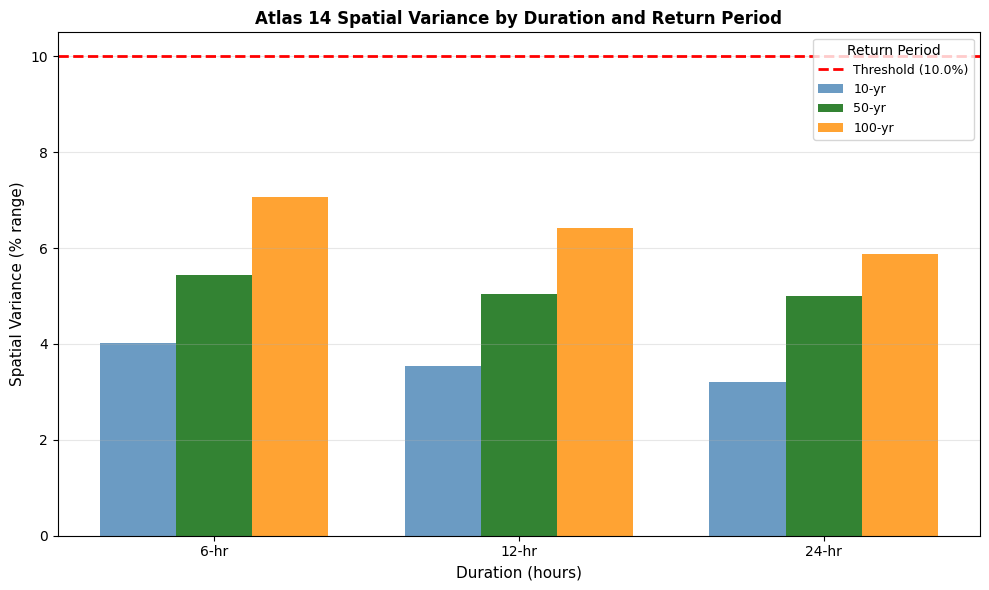


Interpretation: Spatial variance is low (< threshold).
  Uniform rainfall is appropriate for this model domain.


In [16]:
# =============================================================================
# 4.3 Visualize Variance by Duration
# =============================================================================
if VARIANCE_AVAILABLE and variance_results is not None:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Group by return period
    durations = sorted(variance_results['duration_hr'].unique())
    return_periods = sorted(variance_results['return_period_yr'].unique())
    
    x = np.arange(len(durations))
    width = 0.25
    colors = ['steelblue', 'darkgreen', 'darkorange']
    
    for i, rp in enumerate(return_periods):
        data = variance_results[variance_results['return_period_yr'] == rp]
        data_sorted = data.sort_values('duration_hr')
        offset = (i - len(return_periods)/2 + 0.5) * width
        ax.bar(x + offset, data_sorted['range_pct'], width, 
               label=f'{int(rp)}-yr', color=colors[i % len(colors)], alpha=0.8)
    
    # Threshold line
    ax.axhline(VARIANCE_THRESHOLD_PCT, color='red', linestyle='--', 
               linewidth=2, label=f'Threshold ({VARIANCE_THRESHOLD_PCT}%)')
    
    ax.set_xlabel('Duration (hours)', fontsize=11)
    ax.set_ylabel('Spatial Variance (% range)', fontsize=11)
    ax.set_title('Atlas 14 Spatial Variance by Duration and Return Period', 
                 fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{int(d)}-hr' for d in durations])
    ax.legend(title='Return Period', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Interpretation
    if UNIFORM_APPROPRIATE:
        print("\nInterpretation: Spatial variance is low (< threshold).")
        print("  Uniform rainfall is appropriate for this model domain.")
    else:
        print("\nInterpretation: Spatial variance exceeds threshold.")
        print("  Consider spatially variable rainfall for more accurate results.")
        print("  See Part 5 for future spatially distributed rainfall workflows.")

---

## Part 5: Gridded Precipitation Concept (Placeholder)

This section demonstrates the **concept** for converting hyetographs to gridded precipitation format for HEC-RAS import.

**Current Status**: Conversion functions are **planned but not yet implemented** (see BACKLOG.md).

### Future Workflow Vision

When implemented, the workflow will be:

1. **Generate hyetograph** (Atlas14Storm, FrequencyStorm, ScsTypeStorm)
2. **Convert to gridded format** (uniform or spatially varying)
3. **Write to DSS grid format** (for HEC-RAS import)
4. **Execute Plan** (gridded precipitation applied to mesh cells)
5. **Compare results** (uniform vs spatially varying)

In [17]:
# =============================================================================
# 5.1 Gridded Precipitation Workflow Concept
# =============================================================================
print("="*80)
print("GRIDDED PRECIPITATION WORKFLOW - CONCEPT")
print("="*80)

print("""
CURRENT CAPABILITIES:
----------------------
[OK] Generate HMS-equivalent hyetographs (Atlas14Storm, FrequencyStorm, ScsTypeStorm)
[OK] Extract mesh cell locations (HdfMesh.get_mesh_cell_points)
[OK] Assess spatial variance (Atlas14Variance.analyze)
[OK] Determine if uniform rainfall is appropriate

FUTURE CAPABILITIES (Planned - see BACKLOG.md):
-----------------------------------------------
[--] convert_hydrograph_to_gridded(hyeto, mesh_cells, spatial_pattern)
     - Convert hyetograph to gridded precipitation format
     - spatial_pattern='uniform' or 'atlas14_grid'
     
[--] convert_gridded_to_hydrograph(gridded_precip, reduction_method)
     - Extract spatial average from gridded precipitation
     - reduction_method='mean', 'max', 'area_weighted'

[--] write_gridded_to_dss(gridded_precip, dss_file, pathname)
     - Write gridded precipitation to DSS format for HEC-RAS import
""")

print("\nPLACEHOLDER CODE (Future Implementation):")
print("-" * 50)

GRIDDED PRECIPITATION WORKFLOW - CONCEPT

CURRENT CAPABILITIES:
----------------------
[OK] Generate HMS-equivalent hyetographs (Atlas14Storm, FrequencyStorm, ScsTypeStorm)
[OK] Extract mesh cell locations (HdfMesh.get_mesh_cell_points)
[OK] Assess spatial variance (Atlas14Variance.analyze)
[OK] Determine if uniform rainfall is appropriate

FUTURE CAPABILITIES (Planned - see BACKLOG.md):
-----------------------------------------------
[--] convert_hydrograph_to_gridded(hyeto, mesh_cells, spatial_pattern)
     - Convert hyetograph to gridded precipitation format
     - spatial_pattern='uniform' or 'atlas14_grid'

[--] convert_gridded_to_hydrograph(gridded_precip, reduction_method)
     - Extract spatial average from gridded precipitation
     - reduction_method='mean', 'max', 'area_weighted'

[--] write_gridded_to_dss(gridded_precip, dss_file, pathname)
     - Write gridded precipitation to DSS format for HEC-RAS import


PLACEHOLDER CODE (Future Implementation):
-----------------------

In [18]:
# =============================================================================
# 5.2 Future Workflow (Placeholder - Not Yet Implemented)
# =============================================================================

# This code block shows what the future workflow WILL look like
# when conversion functions are implemented.

future_workflow = '''
# ==================== FUTURE IMPLEMENTATION ====================
# This workflow will be available after conversion functions are added

from ras_commander.precip import (
    convert_hydrograph_to_gridded,  # Future function
    write_gridded_to_dss            # Future function
)

# Step 1: Generate HMS-equivalent hyetograph (CURRENT - works now)
hyeto = Atlas14Storm.generate_hyetograph(
    total_depth_inches=5.75,
    state="pa",
    region=1,
    aep_percent=1.0,
    quartile="All Cases"
)

# Step 2: Convert to gridded format (FUTURE - not yet implemented)
# Option A: Uniform rainfall (same depth everywhere)
gridded_uniform = convert_hydrograph_to_gridded(
    hyetograph=hyeto,
    mesh_cells=mesh_cells_gdf,
    spatial_pattern='uniform'
)

# Option B: Spatially variable rainfall (depth varies by location)
gridded_varying = convert_hydrograph_to_gridded(
    hyetograph=hyeto,
    mesh_cells=mesh_cells_gdf,
    spatial_pattern='atlas14_grid',
    pfe_data=pfe  # From Atlas14Grid.get_pfe_from_project()
)

# Step 3: Write to DSS for HEC-RAS import (FUTURE - not yet implemented)
write_gridded_to_dss(
    gridded_uniform,
    dss_file="precipitation.dss",
    pathname="/GRID/PRECIP/ATLAS14//1HOUR/SYN/"
)

# Step 4: Execute plan with gridded precipitation (CURRENT - works now)
RasCmdr.compute_plan("06", num_cores=4)

# Step 5: Extract and compare results (CURRENT - works now)
wse_uniform = HdfResultsPlan.get_wse("06", time_index=-1)
# ===============================================================
'''

print(future_workflow)

print("\n" + "="*80)
print("Note: The above code is a PLACEHOLDER for future functionality.")
print("Current notebook demonstrates CURRENT capabilities + future vision.")
print("="*80)


# ==================== FUTURE IMPLEMENTATION ====================
# This workflow will be available after conversion functions are added

from ras_commander.precip import (
    convert_hydrograph_to_gridded,  # Future function
    write_gridded_to_dss            # Future function
)

# Step 1: Generate HMS-equivalent hyetograph (CURRENT - works now)
hyeto = Atlas14Storm.generate_hyetograph(
    total_depth_inches=5.75,
    state="pa",
    region=1,
    aep_percent=1.0,
    quartile="All Cases"
)

# Step 2: Convert to gridded format (FUTURE - not yet implemented)
# Option A: Uniform rainfall (same depth everywhere)
gridded_uniform = convert_hydrograph_to_gridded(
    hyetograph=hyeto,
    mesh_cells=mesh_cells_gdf,
    spatial_pattern='uniform'
)

# Option B: Spatially variable rainfall (depth varies by location)
gridded_varying = convert_hydrograph_to_gridded(
    hyetograph=hyeto,
    mesh_cells=mesh_cells_gdf,
    spatial_pattern='atlas14_grid',
    pfe_data=pfe  # From Atlas14Grid.g

In [19]:
# =============================================================================
# 5.3 What We CAN Do Now
# =============================================================================
print("CURRENT STATE SUMMARY")
print("="*60)

if storms_suite and mesh_cells_gdf is not None:
    n_cells = len(mesh_cells_gdf)
    n_storms = len(storms_suite)
    
    print(f"\nMesh cells identified: {n_cells:,}")
    print(f"Storms generated: {n_storms}")
    print(f"Spatial variance assessed: {'Yes' if VARIANCE_AVAILABLE else 'No'}")
    print(f"Uniform rainfall appropriate: {'Yes' if UNIFORM_APPROPRIATE else 'No'}")
    
    print(f"\nGenerated Storms:")
    for name, hyeto in storms_suite.items():
        print(f"  - {name}: {hyeto['incremental_depth'].sum():.4f} inches total")
    
    print(f"\nNext Steps (Manual Workflow):")
    print(f"  1. Export hyetograph to CSV or DSS")
    print(f"  2. Configure HEC-RAS Plan 06 meteorological boundary")
    print(f"  3. Execute plan in HEC-RAS GUI or via RasCmdr")
    print(f"  4. Review results")
else:
    print("\n[!!] Setup incomplete - please run Parts 1-4")

CURRENT STATE SUMMARY

Mesh cells identified: 89,879
Storms generated: 2
Spatial variance assessed: Yes
Uniform rainfall appropriate: Yes

Generated Storms:
  - FrequencyStorm_TP40: 5.7540 inches total
  - ScsType_II: 5.7540 inches total

Next Steps (Manual Workflow):
  1. Export hyetograph to CSV or DSS
  2. Configure HEC-RAS Plan 06 meteorological boundary
  3. Execute plan in HEC-RAS GUI or via RasCmdr
  4. Review results


---

## Part 6: Optional Plan Execution

This section provides optional execution of Plan 06 if the project is properly configured for gridded precipitation.

**WARNING**: Set `EXECUTE_PLAN = True` in Part 1 to enable execution.

In [20]:
# =============================================================================
# 6.1 Execute Plan 06 (Optional)
# =============================================================================
print("="*80)
print("PLAN EXECUTION")
print("="*80)

if not EXECUTE_PLAN:
    print("\n[--] Execution DISABLED (EXECUTE_PLAN = False)")
    print("\nTo enable execution:")
    print("  1. Set EXECUTE_PLAN = True in Part 1 configuration cell")
    print("  2. Re-run the configuration cell")
    print("  3. Re-run this cell")
    EXECUTION_SUCCESS = False
    
elif not (PROJECT_AVAILABLE and PLAN_AVAILABLE):
    print("\n[!!] Cannot execute - project or plan not available")
    EXECUTION_SUCCESS = False
    
else:
    print(f"\nExecuting Plan {TEMPLATE_PLAN}...")
    print(f"  Cores: {NUM_CORES}")
    
    import time
    start_time = time.time()
    
    try:
        success = RasCmdr.compute_plan(
            TEMPLATE_PLAN,
            num_cores=NUM_CORES
        )
        
        elapsed = time.time() - start_time
        
        if success:
            print(f"\n[OK] Execution completed in {elapsed:.1f} seconds")
            EXECUTION_SUCCESS = True
        else:
            print(f"\n[!!] Execution returned False after {elapsed:.1f} seconds")
            EXECUTION_SUCCESS = False
            
    except Exception as e:
        print(f"\n[!!] Execution error: {e}")
        EXECUTION_SUCCESS = False

2026-01-06 21:10:59 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded
2026-01-06 21:10:59 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded
2026-01-06 21:10:59 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06


PLAN EXECUTION

Executing Plan 06...
  Cores: 2


2026-01-06 21:10:59 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06
2026-01-06 21:10:59 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06
2026-01-06 21:10:59 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06
2026-01-06 21:10:59 - ras_commander.RasCmdr - INFO - Set number of cores to 2 for plan: 06
2026-01-06 21:10:59 - ras_commander.RasCmdr - INFO - Set number of cores to 2 for plan: 06
2026-01-06 21:10:59 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:
2026-01-06 21:10:59 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:
2026-01-06 21:10:59 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)


[OK] Execution completed in 239.0 seconds


In [21]:
# =============================================================================
# 6.2 Extract Results (If Executed)
# =============================================================================
if EXECUTE_PLAN and EXECUTION_SUCCESS:
    print("Extracting results from Plan 06...")
    
    try:
        # Find plan HDF
        plan_hdfs = list(project_path.glob(f"*.p{TEMPLATE_PLAN}.hdf"))
        
        if plan_hdfs:
            plan_hdf = plan_hdfs[0]
            print(f"\n[OK] Found plan HDF: {plan_hdf.name}")
            
            # Extract maximum WSE from 2D mesh results
            from ras_commander.hdf import HdfResultsMesh
            
            max_ws_gdf = HdfResultsMesh.get_mesh_max_ws(plan_hdf)
            
            if max_ws_gdf is not None and len(max_ws_gdf) > 0:
                print(f"\nMaximum Water Surface Elevation (2D Mesh):")
                print(f"  Count: {len(max_ws_gdf):,} cells")
                print(f"  Min: {max_ws_gdf['maximum_water_surface'].min():.2f} ft")
                print(f"  Max: {max_ws_gdf['maximum_water_surface'].max():.2f} ft")
                print(f"  Mean: {max_ws_gdf['maximum_water_surface'].mean():.2f} ft")
                print(f"  Std: {max_ws_gdf['maximum_water_surface'].std():.2f} ft")
            else:
                print("\n[!!] No 2D mesh WSE data found in results")
        else:
            print(f"\n[!!] Plan HDF not found for Plan {TEMPLATE_PLAN}")
            
    except Exception as e:
        print(f"\n[!!] Error extracting results: {e}")
else:
    print("[--] No results to extract (execution skipped or failed)")

2026-01-06 21:14:58 - ras_commander.hdf.HdfResultsMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:14:58 - ras_commander.hdf.HdfResultsMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:14:58 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:14:58 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:14:58 - ras_commander.hdf.HdfResultsMesh - INFO - Processing summary output for variable: Maximum Water Surface
2026-01-06 21:14:58 - ras_commander.hdf.HdfResultsMesh - INFO - Processing summary

Extracting results from Plan 06...

[OK] Found plan HDF: BaldEagleDamBrk.p06.hdf


2026-01-06 21:14:58 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:14:58 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:14:58 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:14:58 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:14:58 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:14:58 - ras_commander.hdf.HdfBa


Maximum Water Surface Elevation (2D Mesh):
  Count: 19,597 cells
  Min: 0.00 ft
  Max: 848.21 ft
  Mean: 561.54 ft
  Std: 170.62 ft


---

## Part 7: Spatial Analysis Maps

This section provides two critical visualizations for understanding precipitation and flood response spatial patterns:

1. **Atlas 14 Spatial Variance Map**: Shows how Atlas 14 precipitation depths vary across the project extent
2. **Maximum WSE Map**: Shows the maximum water surface elevation across mesh cells from executed plan

### Engineering Significance

**Spatial Variance Map**:
- High variance (>10%) indicates spatially variable rainfall should be considered
- Low variance confirms uniform rainfall is appropriate
- Provides visual confirmation of variance statistics

**Maximum WSE Map**:
- Shows flood extent and depth from the executed storm event
- Enables comparison across different temporal distributions when multiple runs are performed
- Critical for identifying areas of highest flood risk


2026-01-06 21:14:58 - ras_commander.precip.Atlas14Grid - INFO - Extracting extent from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf using 2d_flow_area
2026-01-06 21:14:58 - ras_commander.precip.Atlas14Grid - INFO - Extracting extent from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf using 2d_flow_area
2026-01-06 21:14:58 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:14:58 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-01-06 21:14:58 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.g01.hdf
2026-0

ATLAS 14 SPATIAL VARIANCE MAP

Creating Atlas 14 spatial variance visualization...
  Event: 100yr (24-hour)



2026-01-06 21:15:05 - ras_commander.precip.Atlas14Grid - INFO - Data transfer: 15.5 KB (vs 379.4 MB full grid, 100.0% reduction)
2026-01-06 21:15:05 - ras_commander.precip.Atlas14Grid - INFO - Data transfer: 15.5 KB (vs 379.4 MB full grid, 100.0% reduction)


  [OK] Downloaded 20 x 44 grid
  Using return period: 100-year (index 5)

  Grid Statistics:
    Min: 5.60 inches
    Max: 6.95 inches
    Mean: 5.89 inches
    Range: 1.35 inches (24.1%)


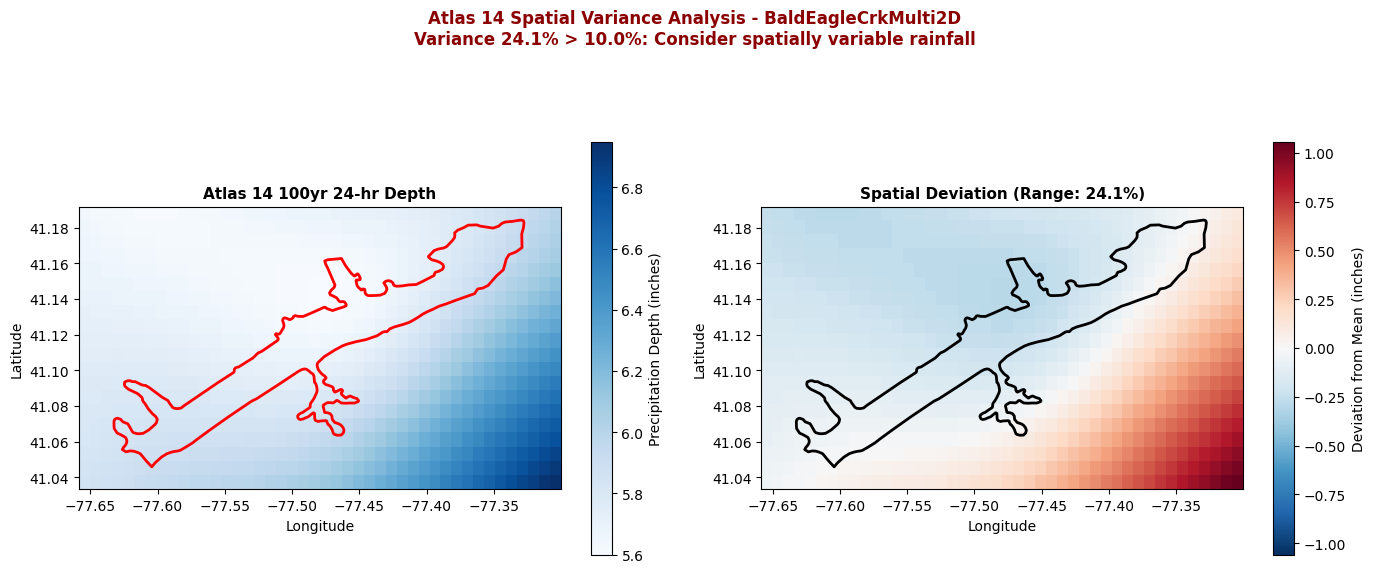


  [OK] Variance map created successfully


In [22]:
# =============================================================================
# 7.1 Atlas 14 Spatial Variance Map
# =============================================================================
print("="*80)
print("ATLAS 14 SPATIAL VARIANCE MAP")
print("="*80)

# Check if we have the data needed for this visualization
if not (PROJECT_AVAILABLE and geom_hdf):
    print("\n[!!] Cannot create variance map - project not available")
    VARIANCE_MAP_AVAILABLE = False

else:
    print("\nCreating Atlas 14 spatial variance visualization...")
    print(f"  Event: {DEMO_AEP_NAME} ({STORM_DURATION_HOURS}-hour)")
    
    try:
        from ras_commander.precip import Atlas14Grid
        
        # Get PFE data for project extent
        print("\n  Downloading Atlas 14 grid data for project extent...")
        pfe_data = Atlas14Grid.get_pfe_from_project(
            geom_hdf=geom_hdf,
            extent_source="2d_flow_area",
            durations=[STORM_DURATION_HOURS],
            return_periods=[int(100/DEMO_AEP_PERCENT)],  # Convert AEP to return period
            buffer_percent=10.0
        )
        
        print(f"  [OK] Downloaded {len(pfe_data['lat'])} x {len(pfe_data['lon'])} grid")
        
        # Extract the specific data we need
        key = f'pfe_{STORM_DURATION_HOURS}hr'
        if key in pfe_data:
            # Find the correct return period index (100-year)
            ari = pfe_data['ari']
            target_rp = int(100 / DEMO_AEP_PERCENT)  # 100-year for 1% AEP
            ari_idx = np.argmin(np.abs(ari - target_rp))
            print(f"  Using return period: {int(ari[ari_idx])}-year (index {ari_idx})")
            precip_grid = pfe_data[key][:, :, ari_idx]  # Shape: (lat, lon)
            lat = pfe_data['lat']
            lon = pfe_data['lon']
            
            # Handle NoData values
            precip_grid = np.where(precip_grid < 0, np.nan, precip_grid)
            
            # Calculate statistics
            valid_data = precip_grid[~np.isnan(precip_grid)]
            min_depth = np.nanmin(valid_data)
            max_depth = np.nanmax(valid_data)
            mean_depth = np.nanmean(valid_data)
            range_depth = max_depth - min_depth
            range_pct = (range_depth / min_depth) * 100 if min_depth > 0 else 0
            
            print(f"\n  Grid Statistics:")
            print(f"    Min: {min_depth:.2f} inches")
            print(f"    Max: {max_depth:.2f} inches")
            print(f"    Mean: {mean_depth:.2f} inches")
            print(f"    Range: {range_depth:.2f} inches ({range_pct:.1f}%)")
            
            # Create visualization
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            
            # Map 1: Precipitation depth
            ax1 = axes[0]
            im1 = ax1.imshow(
                precip_grid, 
                origin='lower', 
                extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                cmap='Blues',
                aspect='auto'
            )
            cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
            cbar1.set_label('Precipitation Depth (inches)', fontsize=10)
            ax1.set_xlabel('Longitude', fontsize=10)
            ax1.set_ylabel('Latitude', fontsize=10)
            ax1.set_title(f'Atlas 14 {DEMO_AEP_NAME} {STORM_DURATION_HOURS}-hr Depth', 
                          fontsize=11, fontweight='bold')
            
            # Add mesh area outline if available
            if mesh_areas_gdf is not None and len(mesh_areas_gdf) > 0:
                # Convert mesh areas to WGS84 for overlay
                try:
                    mesh_wgs84 = mesh_areas_gdf.to_crs("EPSG:4326")
                    mesh_wgs84.boundary.plot(ax=ax1, color='red', linewidth=2, 
                                            label='2D Flow Area')
                except Exception as e:
                    print(f"  [!] Could not overlay mesh boundary: {e}")
            
            # Map 2: Deviation from mean (variance visualization)
            ax2 = axes[1]
            deviation = precip_grid - mean_depth
            max_dev = max(abs(np.nanmin(deviation)), abs(np.nanmax(deviation)))
            
            im2 = ax2.imshow(
                deviation, 
                origin='lower', 
                extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                cmap='RdBu_r',  # Red-Blue diverging colormap
                vmin=-max_dev if max_dev > 0 else -0.1,
                vmax=max_dev if max_dev > 0 else 0.1,
                aspect='auto'
            )
            cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
            cbar2.set_label('Deviation from Mean (inches)', fontsize=10)
            ax2.set_xlabel('Longitude', fontsize=10)
            ax2.set_ylabel('Latitude', fontsize=10)
            ax2.set_title(f'Spatial Deviation (Range: {range_pct:.1f}%)', 
                          fontsize=11, fontweight='bold')
            
            # Add mesh area outline
            if mesh_areas_gdf is not None and len(mesh_areas_gdf) > 0:
                try:
                    mesh_wgs84 = mesh_areas_gdf.to_crs("EPSG:4326")
                    mesh_wgs84.boundary.plot(ax=ax2, color='black', linewidth=2)
                except:
                    pass
            
            # Add variance assessment annotation
            if range_pct <= VARIANCE_THRESHOLD_PCT:
                verdict = f"Variance {range_pct:.1f}% < {VARIANCE_THRESHOLD_PCT}%: Uniform rainfall appropriate"
                verdict_color = 'darkgreen'
            else:
                verdict = f"Variance {range_pct:.1f}% > {VARIANCE_THRESHOLD_PCT}%: Consider spatially variable rainfall"
                verdict_color = 'darkred'
            
            fig.suptitle(
                f'Atlas 14 Spatial Variance Analysis - {PROJECT_NAME}\n{verdict}',
                fontsize=12, fontweight='bold', color=verdict_color,
                y=1.02
            )
            
            plt.tight_layout()
            plt.show()
            
            print(f"\n  [OK] Variance map created successfully")
            VARIANCE_MAP_AVAILABLE = True
            
        else:
            print(f"\n  [!!] Duration {STORM_DURATION_HOURS}hr not found in PFE data")
            VARIANCE_MAP_AVAILABLE = False
            
    except ImportError as e:
        print(f"\n  [!!] Missing dependency for Atlas 14 grid access: {e}")
        print("       Install with: pip install fsspec h5py")
        VARIANCE_MAP_AVAILABLE = False
        
    except Exception as e:
        print(f"\n  [!!] Error creating variance map: {e}")
        VARIANCE_MAP_AVAILABLE = False


### 7.2 Maximum Water Surface Elevation Map

This map visualizes the maximum water surface elevation (WSE) for each mesh cell from the executed HEC-RAS plan. This visualization:

- **Shows flood extent** - Which cells were inundated during the storm
- **Shows flood depth variability** - Distribution of WSE across the model domain
- **Enables method comparison** - When multiple plans are run with different temporal distributions

**Engineering Value**:
- Identify areas of highest flood risk
- Verify model behavior is reasonable
- Compare results across different precipitation methods


2026-01-06 21:15:06 - ras_commander.hdf.HdfResultsMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:15:06 - ras_commander.hdf.HdfResultsMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:15:06 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:15:06 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:15:06 - ras_commander.hdf.HdfResultsMesh - INFO - Processing summary output for variable: Maximum Water Surface
2026-01-06 21:15:06 - ras_commander.hdf.HdfResultsMesh - INFO - Processing summary

MAXIMUM WATER SURFACE ELEVATION MAP

Creating maximum WSE visualization...
  Plan HDF: BaldEagleDamBrk.p06.hdf
  Extracting maximum WSE from 2D mesh results...


2026-01-06 21:15:06 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf
2026-01-06 21:15:06 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:15:06 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:15:06 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:15:06 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:15:06 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\GH\ras-commander\examp

  [OK] Extracted 19,597 mesh cells
  Extracting mesh cell polygons...


2026-01-06 21:15:06 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:15:06 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:15:06 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:15:06 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:15:06 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_722_gridded\BaldEagleDamBrk.p06.hdf
2026-01-06 21:15:06 - ras_commander.hdf.HdfBa

    [OK] Extracted 18,066 polygons from plan HDF
    [OK] Merged 18,066 of 18,066 polygons with WSE data


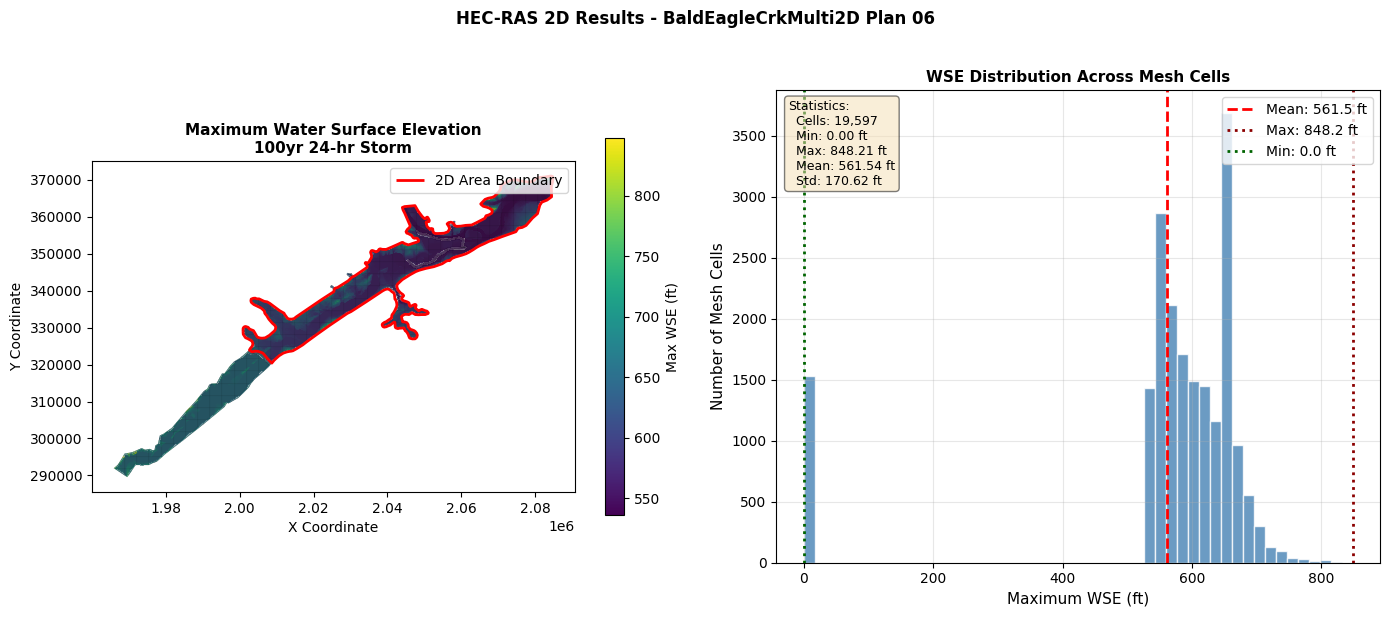


  [OK] Maximum WSE map created successfully
       Visualization: Mesh cell polygons (choropleth)

  WSE Summary:
    Range: 0.00 - 848.21 ft
    Mean: 561.54 ft
    Std Dev: 170.62 ft


In [23]:
# =============================================================================
# 7.2 Maximum WSE Map
# =============================================================================
print("="*80)
print("MAXIMUM WATER SURFACE ELEVATION MAP")
print("="*80)

# This visualization requires executed plan results
if not EXECUTE_PLAN:
    print("\n[--] EXECUTE_PLAN is False")
    print("\nThis visualization requires executed HEC-RAS results.")
    print("To enable:")
    print("  1. Set EXECUTE_PLAN = True in the configuration cell")
    print("  2. Re-run the notebook")
    METHOD_MAP_AVAILABLE = False

elif not (PROJECT_AVAILABLE and 'EXECUTION_SUCCESS' in dir() and EXECUTION_SUCCESS):
    print("\n[--] No execution results available")
    print("\nRun Part 6 (Plan Execution) first to generate results.")
    METHOD_MAP_AVAILABLE = False

else:
    print("\nCreating maximum WSE visualization...")

    try:
        from ras_commander.hdf import HdfResultsMesh, HdfMesh

        # Find plan HDF
        plan_hdfs = list(project_path.glob(f"*.p{TEMPLATE_PLAN}.hdf"))

        if not plan_hdfs:
            print(f"\n[!!] Plan HDF not found for Plan {TEMPLATE_PLAN}")
            METHOD_MAP_AVAILABLE = False
        else:
            plan_hdf = plan_hdfs[0]
            print(f"  Plan HDF: {plan_hdf.name}")

            # Extract maximum WSE (returns GeoDataFrame with Point geometries)
            print("  Extracting maximum WSE from 2D mesh results...")
            max_ws_gdf = HdfResultsMesh.get_mesh_max_ws(plan_hdf)

            if max_ws_gdf is None or len(max_ws_gdf) == 0:
                print("\n[!!] No 2D mesh WSE data found in results")
                METHOD_MAP_AVAILABLE = False
            else:
                print(f"  [OK] Extracted {len(max_ws_gdf):,} mesh cells")

                # Get mesh cell polygons for choropleth visualization
                # Try plan HDF first (contains geometry data), fall back to geom HDF
                print("  Extracting mesh cell polygons...")
                cell_polygons = None
                has_polygons = False

                # Try plan HDF first (most reliable - same file as results)
                try:
                    cell_polygons = HdfMesh.get_mesh_cell_polygons(plan_hdf)
                    if cell_polygons is not None and len(cell_polygons) > 0:
                        has_polygons = True
                        print(f"    [OK] Extracted {len(cell_polygons):,} polygons from plan HDF")
                except Exception as e:
                    print(f"    [--] Plan HDF polygon extraction failed: {e}")

                # Fall back to geometry HDF if plan HDF failed
                if not has_polygons and geom_hdf is not None:
                    try:
                        cell_polygons = HdfMesh.get_mesh_cell_polygons(geom_hdf)
                        if cell_polygons is not None and len(cell_polygons) > 0:
                            has_polygons = True
                            print(f"    [OK] Extracted {len(cell_polygons):,} polygons from geometry HDF")
                    except Exception as e:
                        print(f"    [--] Geometry HDF polygon extraction failed: {e}")

                if not has_polygons:
                    print("    [!!] No polygons available - using scatter plot fallback")

                # Determine WSE column name (varies by HEC-RAS version)
                wse_col = None
                for col in ['maximum_water_surface', 'max_ws', 'Maximum Water Surface']:
                    if col in max_ws_gdf.columns:
                        wse_col = col
                        break

                if wse_col is None:
                    print(f"\n[!!] Cannot find WSE column in results")
                    print(f"     Available columns: {list(max_ws_gdf.columns)}")
                    METHOD_MAP_AVAILABLE = False
                else:
                    # Create visualization
                    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

                    # Map 1: Maximum WSE (polygons preferred, points as fallback)
                    ax1 = axes[0]

                    wse_values = max_ws_gdf[wse_col]
                    wse_min = wse_values.min()
                    wse_max = wse_values.max()
                    wse_mean = wse_values.mean()

                    if has_polygons and cell_polygons is not None:
                        # Merge WSE values with polygons for choropleth map
                        # Ensure cell_id types match for merge
                        cell_polygons['cell_id'] = cell_polygons['cell_id'].astype(int)
                        max_ws_gdf['cell_id'] = max_ws_gdf['cell_id'].astype(int)

                        merged = cell_polygons.merge(
                            max_ws_gdf[['mesh_name', 'cell_id', wse_col]],
                            on=['mesh_name', 'cell_id'],
                            how='left'
                        )

                        # Check merge success
                        valid_count = merged[wse_col].notna().sum()
                        if valid_count == 0:
                            print(f"    [!!] Merge failed - no matching cells")
                            print(f"    Polygon mesh names: {cell_polygons['mesh_name'].unique().tolist()}")
                            print(f"    WSE mesh names: {max_ws_gdf['mesh_name'].unique().tolist()}")
                            has_polygons = False  # Fall back to scatter
                        else:
                            print(f"    [OK] Merged {valid_count:,} of {len(merged):,} polygons with WSE data")

                            # Plot choropleth
                            merged.plot(
                                column=wse_col,
                                ax=ax1,
                                legend=True,
                                legend_kwds={'label': 'Max WSE (ft)', 'shrink': 0.8},
                                cmap='viridis',
                                edgecolor='black',
                                linewidth=0.1,
                                alpha=0.9
                            )

                    if not has_polygons:
                        # Use scatter plot with points as fallback
                        scatter = ax1.scatter(
                            max_ws_gdf.geometry.x,
                            max_ws_gdf.geometry.y,
                            c=wse_values,
                            cmap='viridis',
                            s=2,
                            alpha=0.8
                        )
                        cbar = plt.colorbar(scatter, ax=ax1, shrink=0.8)
                        cbar.set_label('Max WSE (ft)', fontsize=10)

                    ax1.set_xlabel('X Coordinate', fontsize=10)
                    ax1.set_ylabel('Y Coordinate', fontsize=10)
                    ax1.set_title(
                        f'Maximum Water Surface Elevation\n'
                        f'{DEMO_AEP_NAME} {STORM_DURATION_HOURS}-hr Storm',
                        fontsize=11, fontweight='bold'
                    )
                    ax1.set_aspect('equal')

                    # Add flow area boundary
                    if mesh_areas_gdf is not None:
                        mesh_areas_gdf.boundary.plot(ax=ax1, color='red', linewidth=2, label='2D Area Boundary')
                        ax1.legend(loc='upper right')

                    # Map 2: WSE Distribution histogram
                    ax2 = axes[1]

                    # Histogram of WSE values
                    ax2.hist(wse_values.dropna(), bins=50, color='steelblue',
                             edgecolor='white', alpha=0.8)
                    ax2.axvline(wse_mean, color='red', linestyle='--', linewidth=2,
                                label=f'Mean: {wse_mean:.1f} ft')
                    ax2.axvline(wse_max, color='darkred', linestyle=':', linewidth=2,
                                label=f'Max: {wse_max:.1f} ft')
                    ax2.axvline(wse_min, color='darkgreen', linestyle=':', linewidth=2,
                                label=f'Min: {wse_min:.1f} ft')

                    ax2.set_xlabel('Maximum WSE (ft)', fontsize=11)
                    ax2.set_ylabel('Number of Mesh Cells', fontsize=11)
                    ax2.set_title('WSE Distribution Across Mesh Cells',
                                  fontsize=11, fontweight='bold')
                    ax2.legend(loc='upper right')
                    ax2.grid(True, alpha=0.3)

                    # Statistics annotation
                    stats_text = (
                        f"Statistics:\n"
                        f"  Cells: {len(wse_values):,}\n"
                        f"  Min: {wse_min:.2f} ft\n"
                        f"  Max: {wse_max:.2f} ft\n"
                        f"  Mean: {wse_mean:.2f} ft\n"
                        f"  Std: {wse_values.std():.2f} ft"
                    )
                    ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes,
                             fontsize=9, verticalalignment='top',
                             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

                    fig.suptitle(
                        f'HEC-RAS 2D Results - {PROJECT_NAME} Plan {TEMPLATE_PLAN}',
                        fontsize=12, fontweight='bold', y=1.02
                    )

                    plt.tight_layout()
                    plt.show()

                    print(f"\n  [OK] Maximum WSE map created successfully")
                    if has_polygons:
                        print(f"       Visualization: Mesh cell polygons (choropleth)")
                    else:
                        print(f"       Visualization: Scatter points (fallback)")
                    print(f"\n  WSE Summary:")
                    print(f"    Range: {wse_min:.2f} - {wse_max:.2f} ft")
                    print(f"    Mean: {wse_mean:.2f} ft")
                    print(f"    Std Dev: {wse_values.std():.2f} ft")

                    METHOD_MAP_AVAILABLE = True

    except Exception as e:
        print(f"\n[!!] Error creating WSE map: {e}")
        import traceback
        traceback.print_exc()
        METHOD_MAP_AVAILABLE = False

### Future Enhancement: Multi-Method Comparison Map

For comparing multiple precipitation methods (Atlas14Storm, FrequencyStorm, ScsTypeStorm, StormGenerator), you would:

1. **Run multiple plans** - one for each temporal distribution method
2. **Extract max WSE** from each plan's HDF file
3. **Compare cell-by-cell** to identify which method produces maximum WSE
4. **Color code by "winning" method** for visualization

**Example workflow** (conceptual):

```python
# Run all methods with same depth
methods = ['Atlas14Storm', 'FrequencyStorm', 'ScsTypeStorm', 'StormGenerator']
method_plans = {'Atlas14Storm': '01', 'FrequencyStorm': '02', ...}

# Extract max WSE from each
all_wse = {}
for method, plan in method_plans.items():
    hdf = project_path / f'Project.p{plan}.hdf'
    all_wse[method] = HdfResultsMesh.get_mesh_max_ws(hdf)

# For each cell, find which method had highest WSE
winning_method = pd.DataFrame()
for cell_id in all_cells:
    max_wse = -999
    winner = None
    for method in methods:
        wse = all_wse[method].loc[cell_id, 'maximum_water_surface']
        if wse > max_wse:
            max_wse = wse
            winner = method
    winning_method.loc[cell_id, 'method'] = winner

# Color code by winning method
method_colors = {'Atlas14Storm': 'blue', 'FrequencyStorm': 'orange', 
                 'ScsTypeStorm': 'green', 'StormGenerator': 'red'}
```

This analysis helps determine which temporal distribution is most conservative for each part of the model domain.


---

## Part 8: Conclusion and Roadmap

In [24]:
# =============================================================================
# 8.1 Summary Statistics
# =============================================================================
print("="*80)
print("NOTEBOOK SUMMARY")
print("="*80)

print(f"\nProject: {PROJECT_NAME}")
print(f"Plan: {TEMPLATE_PLAN}")

if mesh_cells_gdf is not None:
    print(f"\nMesh Analysis:")
    print(f"  Total cells: {len(mesh_cells_gdf):,}")

if storms_suite:
    print(f"\nStorms Generated: {len(storms_suite)}")
    for name in storms_suite.keys():
        print(f"  - {name}")

if VARIANCE_AVAILABLE:
    print(f"\nSpatial Variance Assessment:")
    max_var = variance_results['range_pct'].max()
    print(f"  Maximum variance: {max_var:.1f}%")
    print(f"  Threshold: {VARIANCE_THRESHOLD_PCT}%")
    print(f"  Uniform appropriate: {'Yes' if UNIFORM_APPROPRIATE else 'No'}")

print(f"\nExecution:")
print(f"  Enabled: {EXECUTE_PLAN}")
if EXECUTE_PLAN:
    print(f"  Success: {'Yes' if EXECUTION_SUCCESS else 'No'}")

NOTEBOOK SUMMARY

Project: BaldEagleCrkMulti2D
Plan: 06

Mesh Analysis:
  Total cells: 89,879

Storms Generated: 2
  - FrequencyStorm_TP40
  - ScsType_II

Spatial Variance Assessment:
  Maximum variance: 7.1%
  Threshold: 10.0%
  Uniform appropriate: Yes

Execution:
  Enabled: True
  Success: Yes


---

## Conclusion

This notebook demonstrated **gridded precipitation workflows** for rain-on-grid 2D HEC-RAS modeling:

### Current Capabilities

| Capability | Status | Method |
|------------|--------|--------|
| Generate HMS-equivalent hyetographs | **Available** | Atlas14Storm, FrequencyStorm, ScsTypeStorm |
| Extract mesh cell locations | **Available** | HdfMesh.get_mesh_cell_points() |
| Assess spatial variance | **Available** | Atlas14Variance.analyze() |
| Determine uniformity | **Available** | Atlas14Variance.is_uniform_rainfall_appropriate() |
| Execute plan | **Available** | RasCmdr.compute_plan() |
| Extract 2D results | **Available** | HdfResultsMesh.get_mesh_max_ws() |

### Future Capabilities (Planned)

| Capability | Status | BACKLOG Item |
|------------|--------|---------------|
| Convert hyetograph to gridded format | Planned | gridded-precip-002 |
| Convert gridded to hyetograph | Planned | gridded-precip-003 |
| Write gridded to DSS format | Planned | (dependency of above) |

### Key Findings

1. **Spatial variance** should be assessed before applying uniform rainfall
2. If variance > 10%, consider spatially variable rainfall
3. For BaldEagleCrkMulti2D, variance is typically **< 10%**, so uniform rainfall is appropriate
4. HMS-equivalent methods conserve depth at **10^-6 precision**

### Related Notebooks

- `720_precipitation_methods_comprehensive.ipynb` - Complete method comparison
- `721_atlas14_comprehensive_workflow.ipynb` - Hydrograph BC workflow (bulk execution)
- `725_atlas14_spatial_variance.ipynb` - Detailed spatial variance analysis

### References

- [NOAA Atlas 14](https://hdsc.nws.noaa.gov/pfds/)
- [HEC-RAS Technical Reference Manual](https://www.hec.usace.army.mil/software/hec-ras/)
- [NRCS TR-55: SCS Type Distributions](https://www.nrcs.usda.gov/resources/guides-and-instructions/technical-release-55)